In [1]:
# %matplotlib widget

## Imports

In [2]:
# modified from test.ipynb and main.py

from pylab import *
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition


warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [3]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm.auto import tqdm

In [4]:
from loop import *

## miniSCOT Functions

In [5]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336*1,
        'num_batteries': int(x[0])
    }

    if len(x) == 2:
        kwargs.update({
            'max_battery_capacity': int(x[1])
        })
        
    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [6]:
def f(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    Y = []
    for x in X:
        cum_reward = invoke_miniscot(x)

        # Note that we negate the reward; want to find min
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [7]:
def f_multiprocess(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs using multiprocessing.

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    
    # Set to None to use all available CPU
    max_pool = None
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(invoke_miniscot, X),
                total=X.shape[0]
            )
        )

    # Note that we negate the reward; want to find min
    Y = -np.reshape(np.array(Y), (-1, 1))
    return Y

## Plotting Functions

In [8]:
def plot_reward(X, Y, labels):
    """
    Plots reward against a maximum of two dimensions.
    """

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(12, 12))

    order = np.argsort(X[:,0])
    
    if X.shape[1] == 1:
        ax = plt.axes()
        ax.plot(X[order,0], Y[order])
        ax.set_xlabel(labels[0])
        ax.set_ylabel("Cumulative reward")
    elif X.shape[1] == 2:
        ax = plt.axes(projection='3d')
        im = ax.plot_trisurf(X[order,0].flatten(), X[order,1].flatten(), Y[order].flatten(), cmap=cm.get_cmap('autumn'))
        fig.colorbar(im)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel("Cumulative reward")  # (£/MWh)
    else:
        raise ValueError('X has too many dimensions to plot - max 2 allowed')

    return fig, ax

## Investigation Parameter Space

In [9]:
max_num_batteries = 1000
min_battery_capacity = 90
max_battery_capacity = 110
num_data_points = 10

timsteps_per_week = 336
num_weeks = 52

In [10]:
num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

# parameter_space = ParameterSpace([num_batteries])
parameter_space = ParameterSpace([num_batteries, max_battery_capacities])

design = RandomDesign(parameter_space)

X = design.get_samples(num_data_points)
X

array([[794,  92],
       [621, 100],
       [117, 101],
       [986,  91],
       [974,  96],
       [417,  94],
       [635, 110],
       [ 24,  94],
       [347, 107],
       [981,  93]])

## GP Kernel Exploration

In [11]:
num_data_points = 10
X = design.get_samples(num_data_points)
Y = f_multiprocess(X)

100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


----------------------------------------
Prior E<var>, sigma<var>: 1, 100.0
Ga(0.01, 0.01)
----------------------------------------
Prior E<var>, sigma<var>: 10, 100.0
Ga(1, 0.1)
----------------------------------------
Prior E<var>, sigma<var>: 100, 100.0
Ga(1e+02, 1)
----------------------------------------
Prior E<var>, sigma<var>: 1000, 100.0
Ga(1e+04, 10)


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


GP_regression.,value,constraints,priors
sum.rbf.variance,800331.789532537,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,339188.04704590084,+ve,"Ga(1e+03, 1)"
Gaussian_noise.variance,1e-10,+ve fixed,


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


  index  |  GP_regression.sum.rbf.variance  |  constraints  |     priors    
  [0]    |                 800331.78953254  |      +ve      |  Ga(1e+04, 10)
  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                        77.08626903  |      +ve      |  Ga(10, 0.1)
  [1]    |                        11.29734877  |      +ve      |  Ga(10, 0.1)
Model objective: 16590438.028335787
Model log-likelihood: -8331569.230110902


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
100%|██████████| 3/3 [00:19<00:00,  6.37s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradi

Successfully ran loop
minimum X: 
[382.  95.]
minimum Y: 
-719699.7405629199
Number of (new) points evaluated: 6 (batch size 3)
[-701181.27616448 -701181.27616448 -701181.27616448 -701181.27616448
 -701181.27616448 -701181.27616448 -701181.27616448 -701181.27616448
 -701181.27616448 -701181.27616448 -719699.74056292 -719699.74056292
 -719699.74056292 -719699.74056292 -719699.74056292 -719699.74056292]


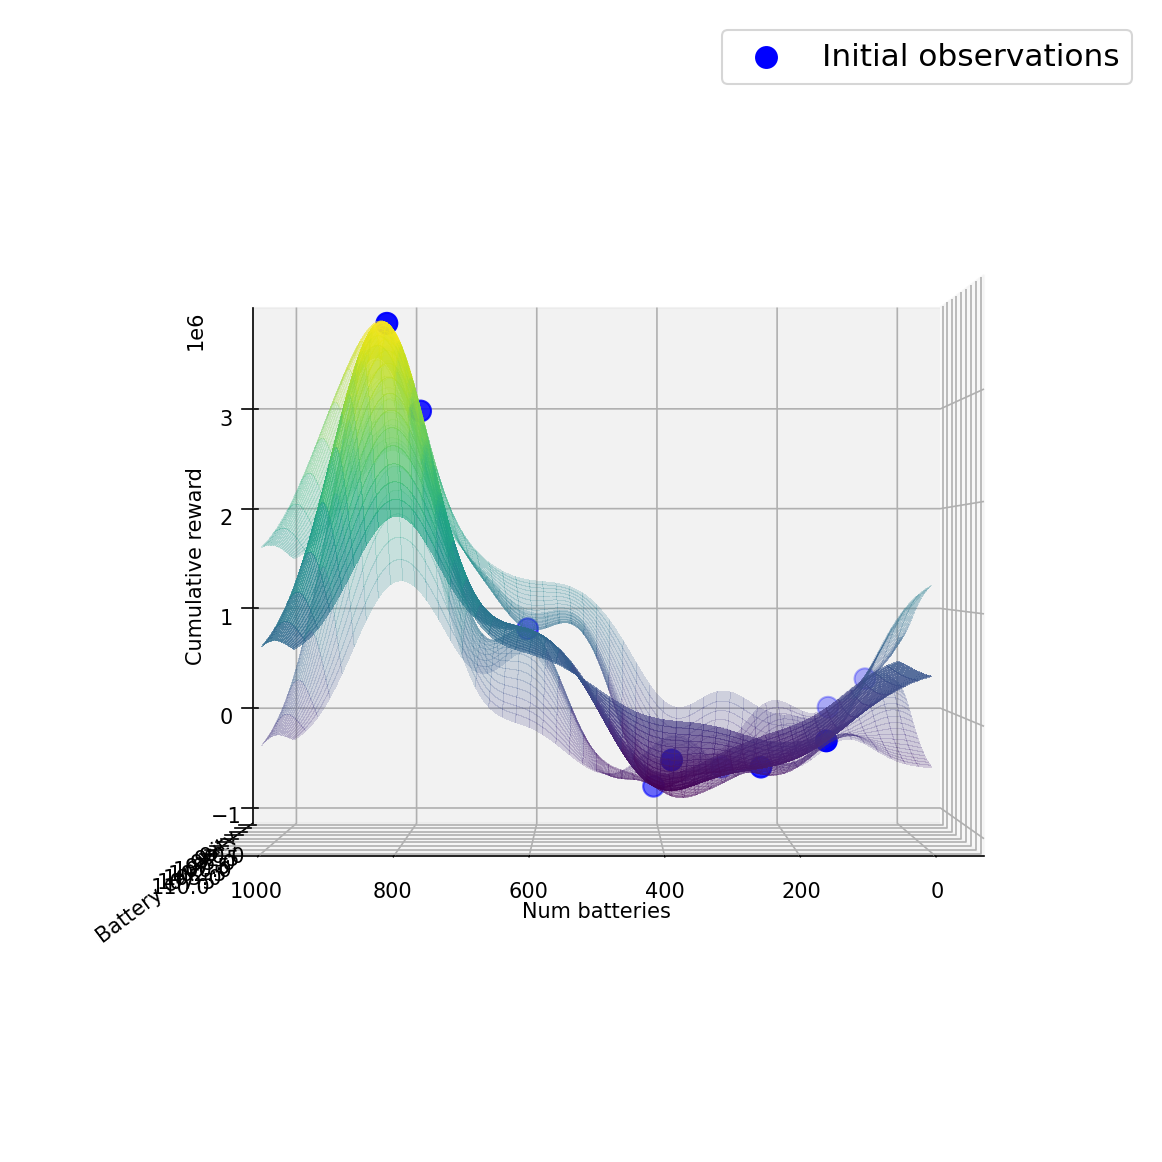

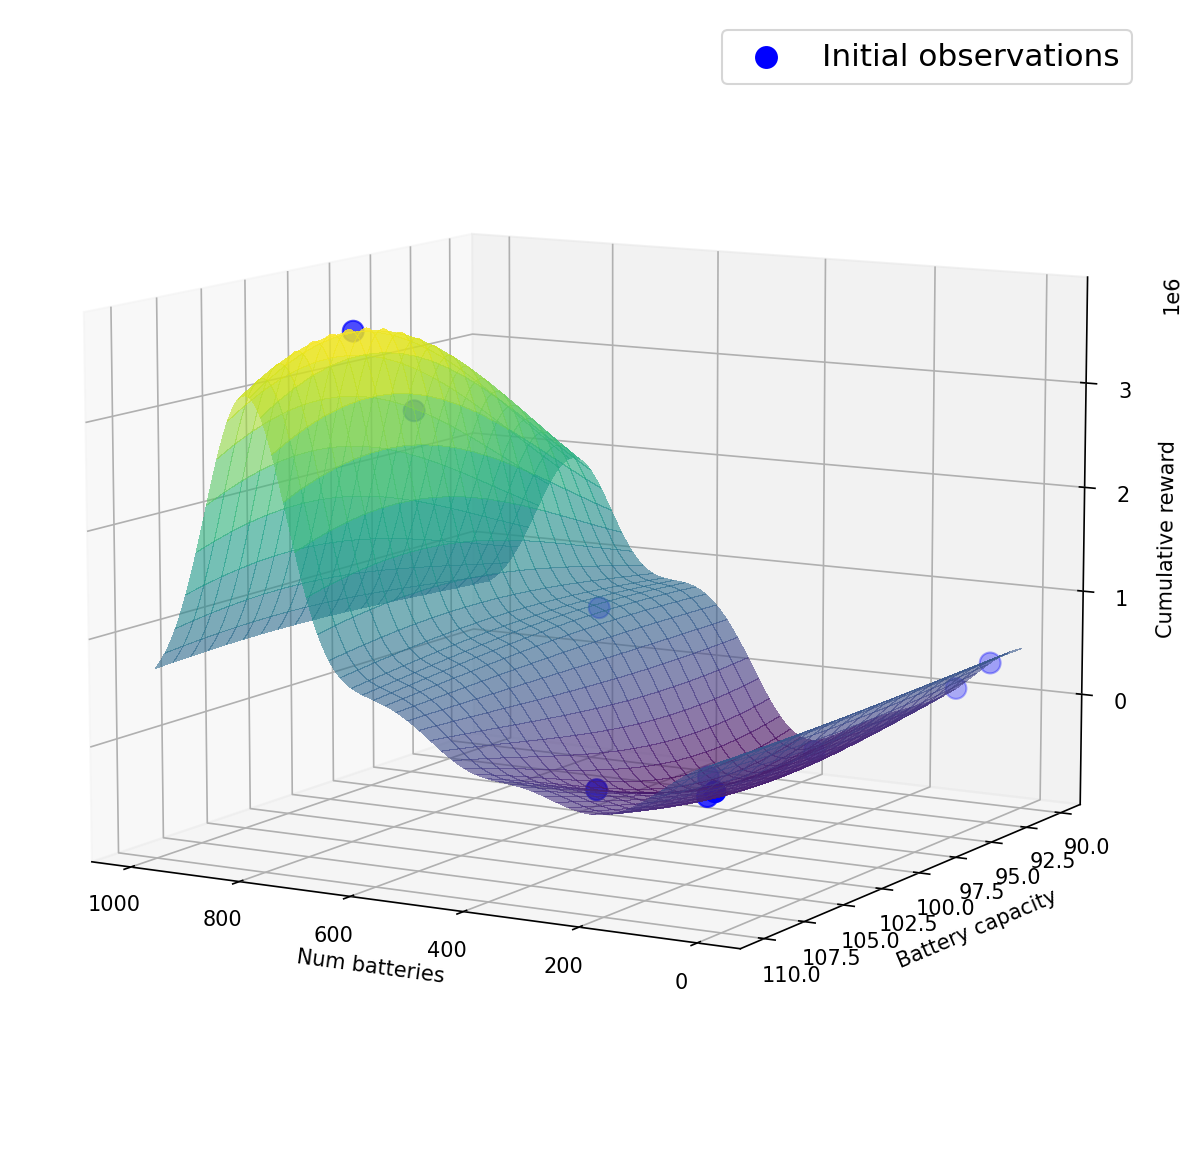

In [116]:
# Some prior distributions for model parameters
v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

# Some prior distributions for model parameters
gpy_model.kern.rbf.variance.set_prior(v_prior)
gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

# gpy_model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1., 10.))
# gpy_model.kern.bias.variance.set_prior(GPy.priors.Gamma.from_EV(1000, 1000.))

gpy_model.Gaussian_noise.variance.constrain_fixed()

# gpy_model.optimize()
gpy_model.optimize_restarts(num_restarts=10, robust=False, verbose=False, parallel=False, num_processes=None, messages=False)

# Logging GP fit
# _ = gpy_model.plot()
display(gpy_model)
print(gpy_model.kern.rbf.variance)
print(gpy_model.kern.rbf.lengthscale)
print("Model objective: {}".format(gpy_model.objective_function()))
print("Model log-likelihood: {}".format(gpy_model.log_likelihood()))

# Save
res = {}
res['obj'] = round(gpy_model.objective_function(), 0)
res['ll'] = round(gpy_model.log_likelihood(), 0)
res['rbf_var'] = round(gpy_model.kern.rbf.variance[0], 0)
res['rbf_l'] = gpy_model.kern.rbf.lengthscale
dic[i] = res

model_emukit = GPyModelWrapper(gpy_model)

# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                        min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T

mu_plot, var_plot = model_emukit.predict(positions)

fig = plt.figure(figsize=(10, 10), dpi=150)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)
surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot+var_plot).reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
        s=100, marker="o", color="b", label="Initial observations")
ax.grid(True)
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")
# plt.title("Initial GP fit with prior setting {}".format(gpy_model.kern.name))
plt.legend(loc='upper right', prop={'size': 15})

# for angle in range(0, 360, 40):
#     ax.view_init(elev=10., azim=angle)
#     plt.savefig('img/kernels/{}_{}.png'.format(gpy_model.kern.name, angle))

ax.view_init(elev=0., azim=90)
# plt.show()

fig = plt.figure(figsize=(10, 10), dpi=150)

ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

# surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape(
#     (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)
# surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot+var_plot).reshape(
#     (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
            s=100, marker="o", color="b", label="Initial observations")
ax.grid(True)
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")
# plt.title("Initial GP fit with prior setting {}".format(gpy_model.kern.name))
plt.legend(loc='upper right', prop={'size': 15})

# for angle in range(0, 360, 40):
#     ax.view_init(elev=10., azim=angle)
#     plt.savefig('img/kernels/{}_{}.png'.format(gpy_model.kern.name, angle))

ax.view_init(elev=10., azim=120)
# plt.show()

# Choose acquisition functionk
ei_acq = ExpectedImprovement(model_emukit)
acq_func = ei_acq

# Load core elements for Bayesian optimization
optimizer = GradientAcquisitionOptimizer(space=parameter_space)

# Create the Bayesian optimization object
batch_size = 3
bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                        space=parameter_space,
                                        acquisition=acq_func,
                                        batch_size=batch_size)

# Run the loop and extract the optimum;  we either complete 10 steps or converge
max_iters = 2
epsilon = 0.01
stopping_condition = (FixedIterationsStoppingCondition(
    i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
print("Successfully ran loop")
successful_sample = True

# Get acquired data
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]
total_num_points = new_Y.shape[0]

results = bayesopt_loop.get_results()
print("minimum X: ")
print(results.minimum_location)
print("minimum Y: ")
print(results.minimum_value)

print("Number of (new) points evaluated: {} (batch size {})".format(
    total_num_points-num_data_points, batch_size))

print(results.best_found_value_per_iteration)


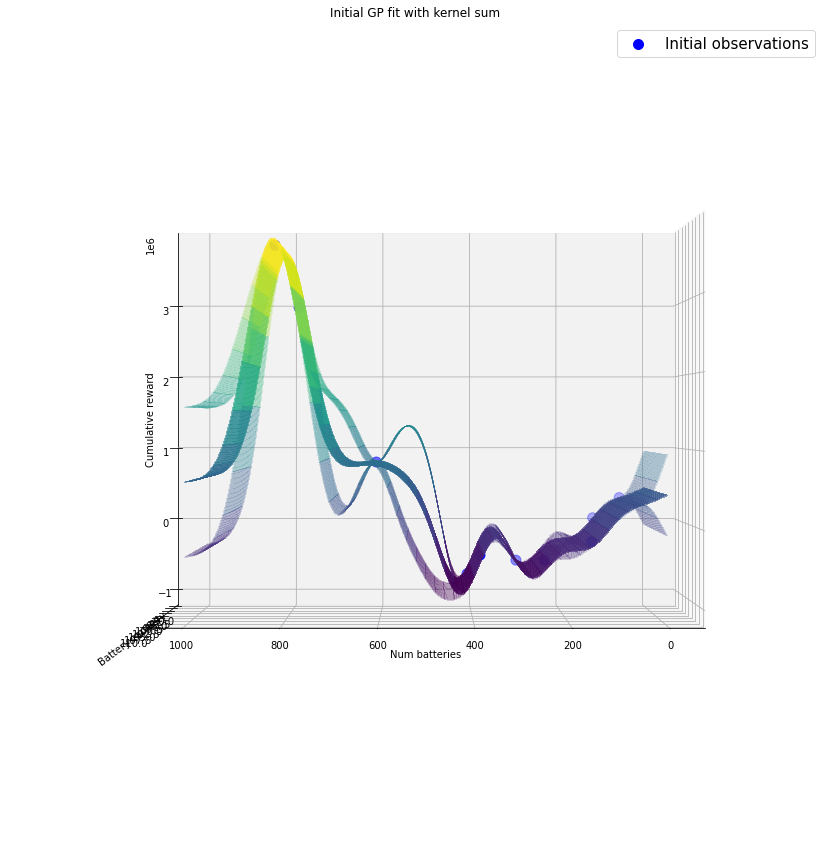

In [46]:
model_emukit = GPyModelWrapper(gpy_model)

# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T

mu_plot, var_plot = model_emukit.predict(positions)

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)
surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot+var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.grid(True)
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")
plt.title("Initial GP fit with kernel {}".format(gpy_model.kern.name))
plt.legend(loc='upper right', prop={'size': 15})


# for angle in range(0, 360, 40):
#     ax.view_init(elev=10., azim=angle)
#     plt.savefig('img/kernels/{}_{}.png'.format(gpy_model.kern.name, angle))
ax.view_init(elev=0., azim=90)
plt.show()


# GP Parameters Fitting

- Variance & Lengthscale

In [62]:
num_data_points=10
X = design.get_samples(num_data_points)
Y = f_multiprocess(X)

100%|██████████| 10/10 [05:27<00:00, 32.75s/it]


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Optimization restart 1/10, f = 652343741.5963936
Optimization restart 2/10, f = 28560637.317740604
Optimization restart 3/10, f = 35496847.207357004
Optimization restart 4/10, f = 8777266873.930052
Optimization restart 5/10, f = 1884681781.5312655
Optimization restart 6/10, f = 34607638.55024204
Optimization restart 7/10, f = 15467544658.118849
Optimization restart 8/10, f = 15568386242.280262
Optimization restart 9/10, f = 13652132989.769836
Optimization restart 10/10, f = 27923769.432302684


GP_regression.,value,constraints,priors
sum.rbf.variance,1213279.871801559,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,570821.6751699025,+ve,"Ga(1e+03, 1)"
Gaussian_noise.variance,1e-10,+ve fixed,"Ga(0.1, 0.1)"


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                         3.13335861  |      +ve      |  Ga(10, 0.1)
  [1]    |                       155.69475947  |      +ve      |  Ga(10, 0.1)
Okay to optimize


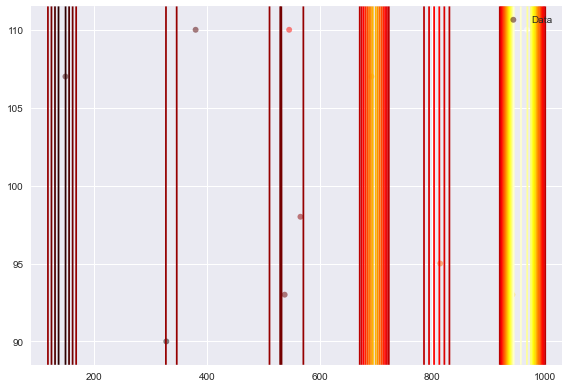

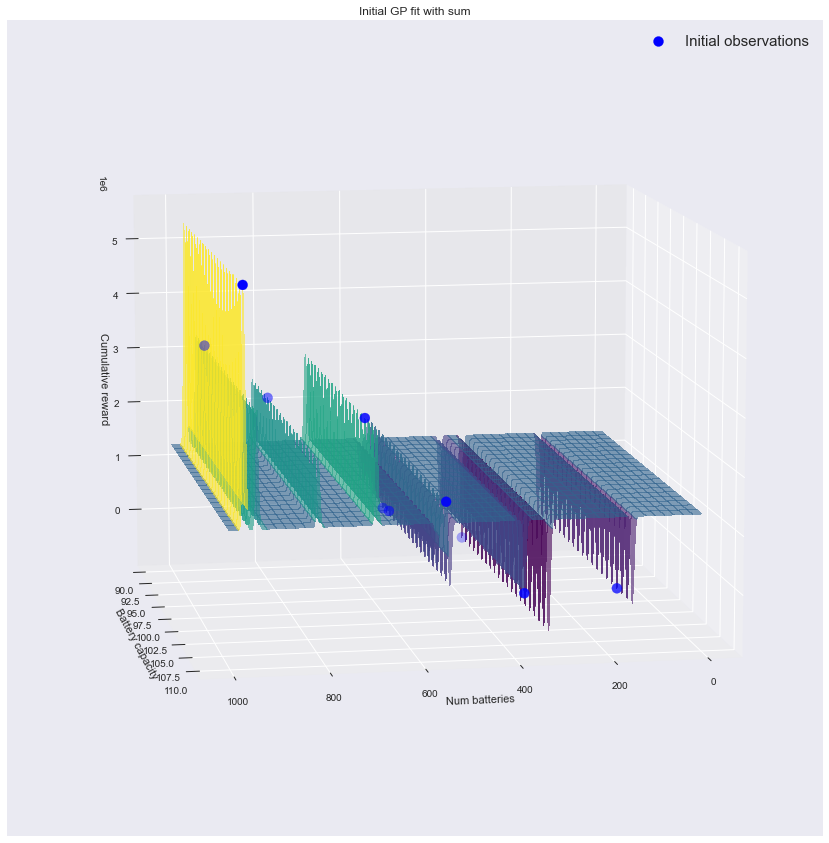

INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
100%|██████████| 3/3 [00:22<00:00,  7.59s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.mode

Successfully ran loop
minimum X: 
[397.  93.]
minimum Y: 
-711014.4321457741
Number of (new) points evaluated: 9 (batch size 3)


In [212]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

#  Plot init values
# plot_reward(X, Y, parameter_space.parameter_names)

# Kernel Specification
kr = GPy.kern.RBF(input_dim=X.shape[1], ARD=True) # lengthscale=2.5, variance=80, ARD=True)
kb = GPy.kern.Bias(input_dim=X.shape[1])
kernel = kr+kb

# Emulator model
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

# Some prior distributions for model parameters
gpy_model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1., 10.))
gpy_model.kern.rbf.variance.set_prior(GPy.priors.Gamma.from_EV(1000, 100.))
gpy_model.kern.rbf.lengthscale.set_prior(GPy.priors.Gamma.from_EV(100, 1000.))  # gamma prior, < l > = 100, var(l) = 1000
gpy_model.kern.bias.variance.set_prior(GPy.priors.Gamma.from_EV(1000, 1000.)) 

gpy_model.Gaussian_noise.variance.constrain_fixed()

# gpy_model.optimize()
gpy_model.optimize_restarts(num_restarts=10, robust=False,
                            verbose=True, parallel=False, num_processes=None, messages=False)


# Logging GP fit
_ = gpy_model.plot()
display(gpy_model)
print(gpy_model.kern.rbf.lengthscale)

print("Okay to optimize")

model_emukit = GPyModelWrapper(gpy_model)

# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T

mu_plot, var_plot = model_emukit.predict(positions)

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

# surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)
# surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot+var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

# fig.colorbar(surf)
ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.grid(True)
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")
plt.title("Initial GP fit with {}".format(gpy_model.kern.name))
plt.legend(loc='upper right', prop={'size': 15})
ax.view_init(elev=10., azim=80)
plt.show()

# Choose acquisition functionk
ei_acq = ExpectedImprovement(model_emukit)
nlcb_acq = NegativeLowerConfidenceBound(model_emukit)
pi_acq = ProbabilityOfImprovement(model_emukit)
# for acq_func, title in [(ei_acq, "EI"), (nlcb_acq, "NLCB"), (pi_acq, "PI")]:

acq_func = ei_acq

# Load core elements for Bayesian optimization
optimizer = GradientAcquisitionOptimizer(space=parameter_space)

# Create the Bayesian optimization object
batch_size = 3
bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                        space=parameter_space,
                                        acquisition=acq_func,
                                        batch_size=batch_size)

# Run the loop and extract the optimum;  we either complete 10 steps or converge
max_iters = 3
epsilon = 0.01
stopping_condition = (FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
print("Successfully ran loop")
successful_sample = True

# Get acquired data
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]
total_num_points = new_Y.shape[0]

results = bayesopt_loop.get_results()
print("minimum X: ")
print(results.minimum_location)
print("minimum Y: ")
print(results.minimum_value)

print("Number of (new) points evaluated: {} (batch size {})".format(total_num_points-num_data_points, batch_size))


In [109]:
results = bayesopt_loop.get_results()
results.minimum_location, results.minimum_value # , results.best_found_value_per_iteration

(array([795.,  98.]), -49066704.85591315)

Plot 3D decision boundary

In [8]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T

mu_plot, var_plot = model_emukit.predict(positions)

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

# surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.10)
# surf_var = ax.plot_surface(me sh_X, mesh_Y, (mu_plot+var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

# fig.colorbar(surf)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

ax.grid(True)
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")
plt.title("GP mean with {}".format(gpy_model.kern.name))
plt.legend(loc='upper right', prop={'size': 15})

# for angle in range(0, 360, 40):
ax.view_init(elev=10., azim=80)

plt.show()


NameError: name 'max_num_batteries' is not defined

Plot actual observation surface

Minimum value found:
[328.  90.] -620552.6527396751


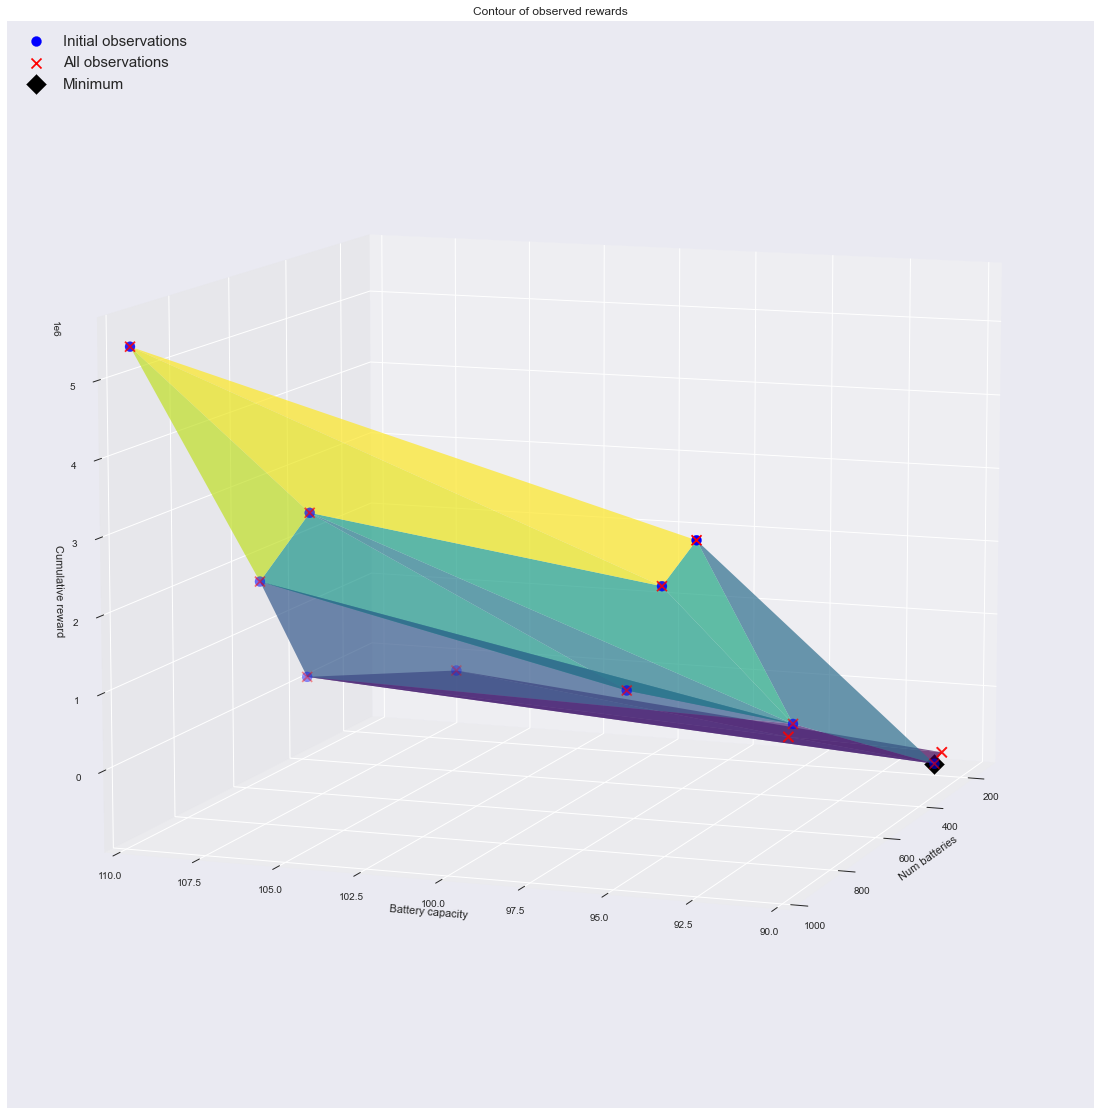

In [205]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')

new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]

x_plot = np.reshape(
    np.array([i for i in range(0, max_num_batteries)]), (-1, 1))
X_plot = np.append(x_plot, np.reshape(
    [100 for i in range(max_num_batteries)], (-1, 1)), axis=1)
mu_plot, var_plot = model_emukit.predict(X_plot)

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('viridis'), alpha=0.70)
# fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)
ax.scatter(min_X[0], min_X[1], min_Y, c='black',
           marker='D', label="Minimum", s=200)

LEGEND_SIZE = 15
ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")

ax.view_init(elev=10., azim=20)
ax.set_ylim(110, 90)
ax.grid(True)
plt.title("Contour of observed rewards")
print("Minimum value found:")
print(min_X, min_Y)
# plt.savefig("img/rq_sim.png")

plt.show()


## Try/except

In [ ]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

successful_sample = False
num_tries = 0
max_num_tries = 3

use_default = False

while not successful_sample and num_tries < max_num_tries:

    print(f"CURRENT ATTEMPT #{num_tries}")

    X = design.get_samples(8)
    Y = f_multiprocess(X)

    # Plot init values
    # plot_reward(X, Y, parameter_space.parameter_names)

    # Kernel Specification
    kr = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=2, variance=9, ARD=True)
    kb = GPy.kern.Bias(input_dim=X.shape[1], variance=1e-5)
    kernel = kr+kb  

    try:
        # Emulator model
        if use_default: gpy_model = GPRegression(X, Y)
        else:
            # Some prior distributions for model parameters
            gpy_model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1., 10.))
            gpy_model.kern.rbf.variance.set_prior(GPy.priors.Gamma.from_EV(10., 100.))
            gpy_model.kern.rbf.lengthscale.set_prior(GPy.priors.Gamma.from_EV(60, 1000.))  # gamma prior, < l > = 120, var(l) = 2000
            gpy_model.Gaussian_noise.variance.constrain_fixed()

            gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

    
        gpy_model.optimize()
        print("Okay to optimize")

        model_emukit = GPyModelWrapper(gpy_model)
        
        # Choose acquisition function
        ei_acq = ExpectedImprovement(model_emukit)
        nlcb_acq = NegativeLowerConfidenceBound(model_emukit)
        pi_acq = ProbabilityOfImprovement(model_emukit)
        acq_func = ei_acq


        # Load core elements for Bayesian optimization
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                    space=parameter_space,
                                                    acquisition=acq_func,
                                                    batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        stopping_condition = (
            FixedIterationsStoppingCondition(
                i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
        )

        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        print("Successfully ran loop")
        successful_sample = True

        # Get acquired data
        new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
        new_order = np.argsort(new_X[:, 0])
        new_X = new_X[new_order, :]
        new_Y = new_Y[new_order]
        
    except:
        num_tries += 1


In [602]:
min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)

min_X, min_Y

(array([557.,  92.]), -4115764.825228045)

Minimum value found:
[332. 102.] 669709.6282651341


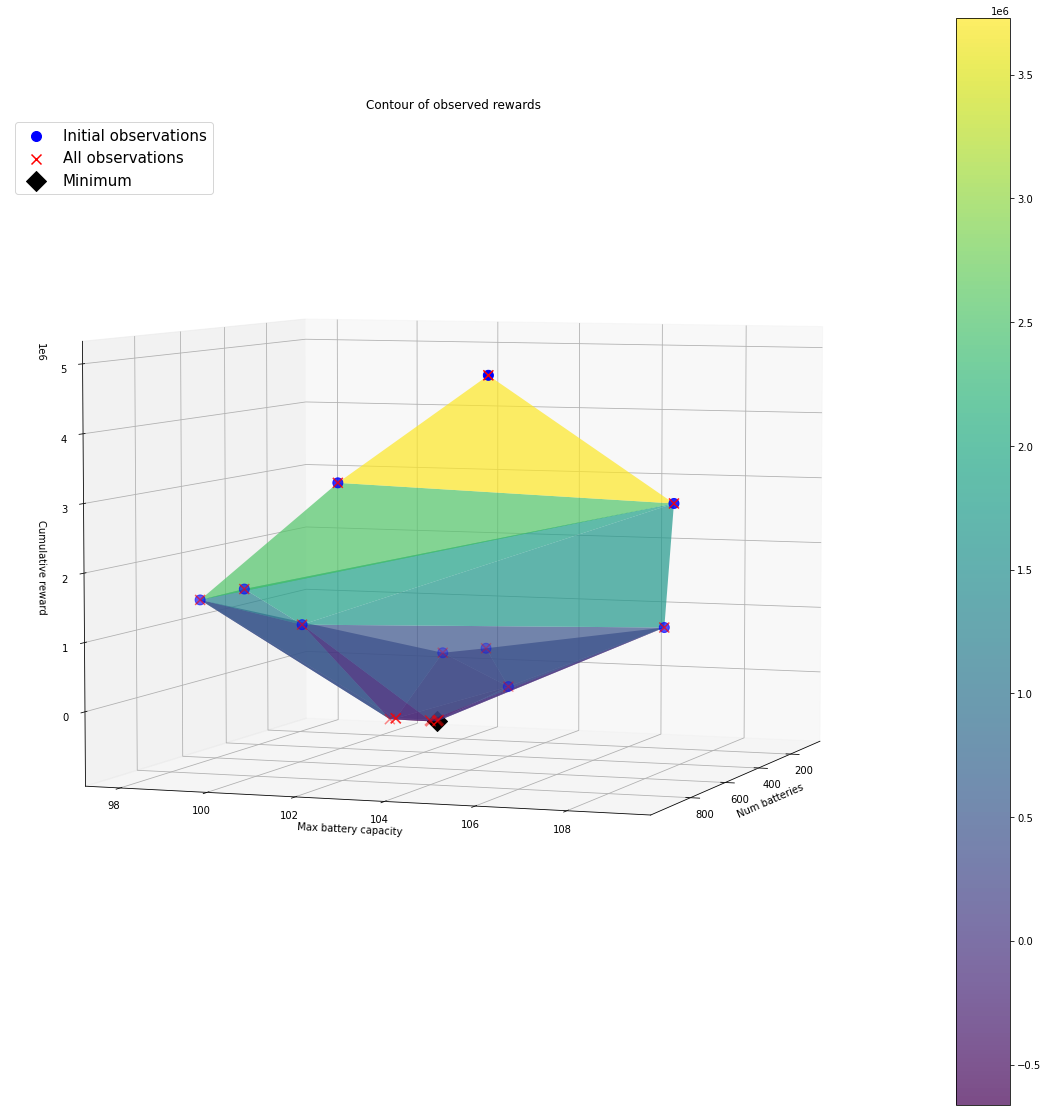

In [23]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')

new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]

x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1, 1))
X_plot = np.append(x_plot, np.reshape(
    [100 for i in range(max_num_batteries)], (-1, 1)), axis=1)
mu_plot, var_plot = model_emukit.predict(X_plot)

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(), new_Y.flatten(), cmap=cm.get_cmap('viridis'), alpha=0.70)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)
ax.scatter(min_X[0], min_X[1], min_Y, c='black',
           marker='D', label="Minimum", s=200)

LEGEND_SIZE = 15
ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel("Num batteries")
ax.set_ylabel("Max battery capacity")
ax.set_zlabel("Cumulative reward")

ax.view_init(elev=5., azim=20)
ax.grid(True)
plt.title("Contour of observed rewards")
print("Minimum value found:")
print(min_X, min_Y)
plt.show()


## Visualize and Get Extrema

In [18]:
min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)

min_X, min_Y


(array([394.,  92.]), -4437379.057100313)

### Simple Plot

(<Figure size 864x864 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='max_battery_capacity'>)

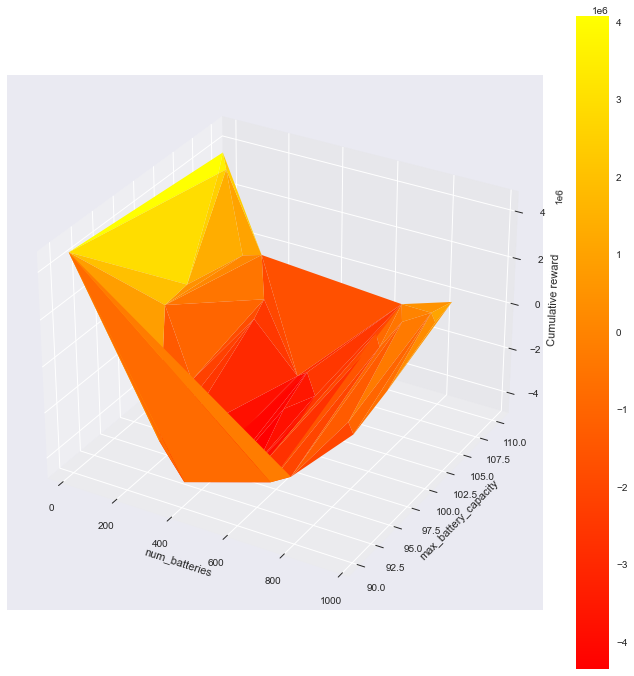

In [27]:
plot_reward(new_X, new_Y, parameter_space.parameter_names)

### 2D Plot

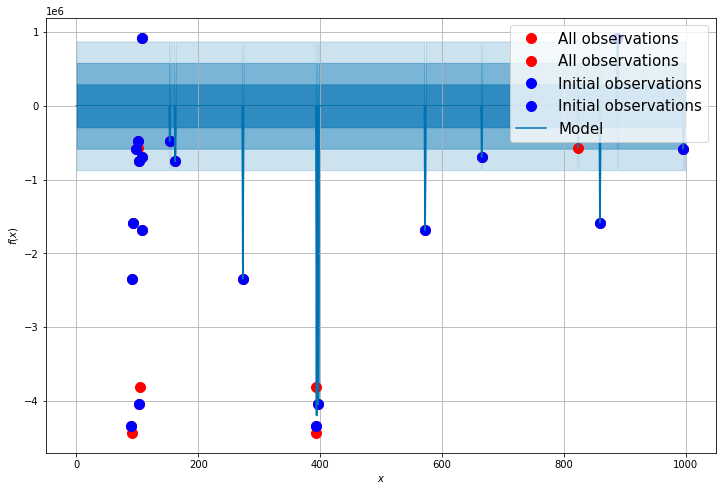

In [19]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc='upper right', prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
# plt.xlim(0, 25)
plt.show()

## 3D Plots

#### Inferred Surface

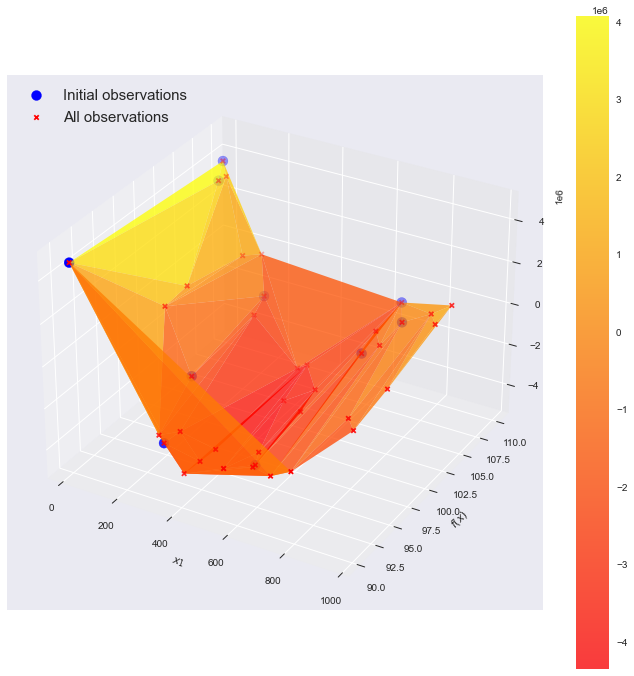

In [33]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)


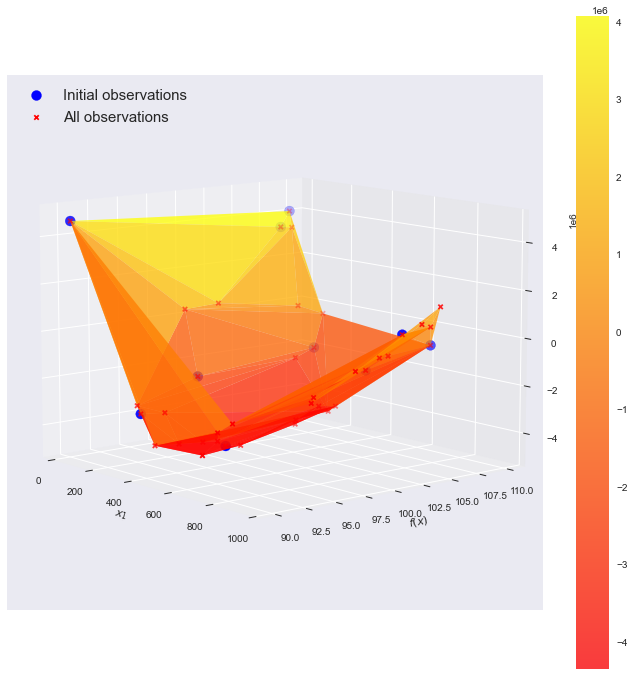

In [44]:
import time
plt.style.use('seaborn-colorblind')
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)

for angle in range(0, 360, 40):
    ax.view_init(elev=10., azim=angle)
    plt.savefig("img/plot_{}.png".format(angle))



#### Prediction Surface

In [631]:
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1, min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
mu_plot, var_plot = model_emukit.predict(positions)

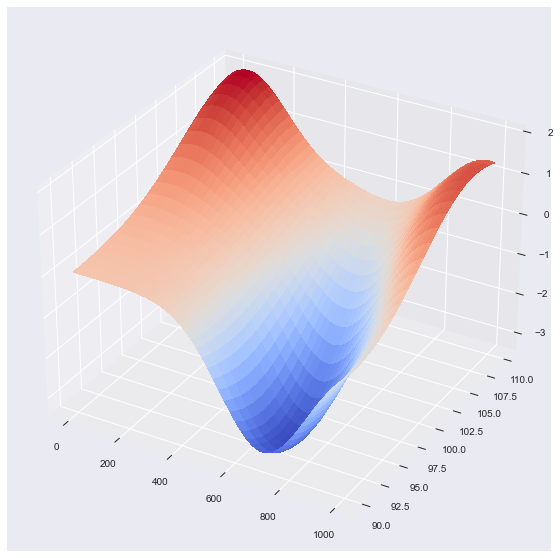

In [632]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape((1000,21)), cmap=cm.coolwarm,linewidth=0, antialiased=False)